In [28]:
!pip install jax==0.4.28

Defaulting to user installation because normal site-packages is not writeable


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmath
import seaborn as sns

import gymnasium as gym
from gymnasium import spaces

from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from itertools import combinations

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.visualization import circuit_drawer, plot_histogram
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator

from qutip import Qobj, basis, tensor
from qutip_qip.operations import gate_sequence_product, Gate, Measurement
from qutip_qip.circuit import QubitCircuit

# Layerwise Quantum DRL
1. Embed UAV memory experience replay parameter data into qubits 1-N.
2. M Layers for updating the parameter theta for gradient descent algorithm using ansatz for LQ-DRL.
3. Entire system works like PPO with a $\theta$ parameter that's updated using gradient descent (computed classically).
3. Gradient descent algorithm provides the updated parameter $\theta$ for the LQ-DRL ansatz.
4. Update $\theta$ in the angle rotation gates for more accurate LQ-DRL computation. 
5. Repeat until convergence of optimal energy efficiency, secrecy rate, etc. 

# Data to be Embedded
Must embed data in $n$ qubits $0, 1 \dots, N-2, N-1$. Table of data to be embedded into the ansatz (quantum circuit) are the following.
[WRITE THE TABLE HERE]

# Reward Shaping Function
Reward should be allocated based on the energy efficiency $\eta(t)$ if $R_{k, n}^{sec} \ge R_{min}^{sec}$, $\forall k$. 
\
$
\Large
\begin{align}
    R(t) = 
    \begin{cases}
        \eta(t), if R_{k, n}^{sec} \ge R_{min}^{sec}, \forall k \\
        0, otherwise
    \end{cases}
\end{align}
$

# Layerwise-Quantum Deep Reinforcement Learning
From Silviranti et. al (2025), the actor network takes 12 encoded inputs (state space dimensions for observation are $2K+4$ dimensions, where $K$ is the number of GUs for NOMA user grouping with a phase-based encoding scheme for the data. 
In the paper, 4 GUs are used within the demonstrated scenario, hence the observation state space has $2(4)+4=12$ dimensions.
For ever $N$ element to be encoded, $N$ qubits will be required. 
For angle encoding, normalise using MinMaxScaler() so that all parameters in the input vector are normalised in the bound of $[-p, p]$, where $p$ is a determined boundary and $p \in [-2\pi, 2\pi]$.  

The critic network takes 17 encoded inputs in the study as its inputs are the observation state space $s$ and the action space $a$, which have $2K+4$ and 5 dimensions, respectively. As $K = 4$ in their results, the critic network has $12+5=17$ input. 

The action space consists of the following:

#### UAV Trajectory
The trajectory is directly related to the UAV's maneuverability which is controlled by its velocity $v$. 

$
\Large
v = \zeta_{v} v_{max}
$

Where $\zeta_{v} \in [0, 1]$ is a constant value. $\zeta_{v}$ should serve as a scaling factor for $v_{max}$ so that the UAV only moves at a scaled fraction of the maximum velocity, i.e., $\zeta_{v}$ is a float that can have any value between 0 & 1.

#### NOMA User Grouping
The optimisation of the NOMA user grouping involves the assignment of the best fitted user group for each $k^{th}$ user at time $t$. 

$
\Large
\begin{Bmatrix}
\begin{bmatrix}
u_{1_{1}}(t), \dots, u_{K_{1}}(t)
\end{bmatrix},
\dots
\begin{bmatrix}
u_{1_{N}}(t), \dots, u_{K_{N}}(t)
\end{bmatrix},
\end{Bmatrix}
$

#### Transmit Power Allocation
Transmit power allocation vectors are sorted from highest to lowest based on the channel gains between the UAV-BS and the user. Higher transmit power is allocated to users with lower channel gains. 

$
\Large
\begin{Bmatrix}
P_{1, n}^{Tx}, \dots, P_{K, n}^{Tx}
\end{Bmatrix}
$

# Encoding Operation
$
\Large
S_{\textbf{x}}: \begin{Bmatrix} 
x_{n}
\end{Bmatrix}_{n=1}^{N}
\xrightarrow[]{} 
\begin{Bmatrix}
\phi_{n}
\end{Bmatrix}_{n=1}^{N}
$

Encoding involves the use of $RX$ gates with the input data scaled by $tanh$, i.e., $\theta_{n} = tanh(x_{n}), \forall n$ and the encoding operation can be expressed as $S_{x} = \bigotimes^{N}_{n=1} RX(tanh(\theta_{n}))$. 

Parameter vector update for $\theta_{g}$, where $G$ is the number of weighted parameters is $S_{\theta_g} = RY(tanh(\theta_{g}))$. This value is fed back into the Layerwise Quantum Embedding portion of the quantum circuitry after the encoding operation $S_{\textbf{x}}$ has occurred. 

# Layerwise Quantum Embedding 
$N = $ Number of inputs 

$M = $ Number of Layers

$G = $ Number of weighted parameters

$
\Large
U_{LQ}^{(1)} (\theta^{(0)}) = \bigotimes_{g=1}^{G} \bigotimes_{n=1}^{N} (S_{\theta_{g}^{(0)}}^{(1)}) \begin{pmatrix}
\Pi_{n=1}^{N} CZ(\phi_{2}^{(0)}|\phi_{1}^{(0)}) \otimes \dots \otimes CZ(\phi_{N}^{(0)}|\phi_{N-1}^{(0)})
\end{pmatrix} (S_{x_{n}}^{(1)})H
$

First layer contains Hadamard gate. Layers $2 \le m \le M$ are made up of the same operations, however, they do not contain the Hadamard gate operation.
Embedding of layers m = 2 to M can be expressed in the following manner:

$
\Large
U_{LQ}^{(2 \le m \le M)} (\theta^{(m-1)}) = \bigotimes_{m=2}^{M} \bigotimes_{g=1}^{G} \bigotimes_{n=1}^{N} (S_{\theta_{g}^{(0)}}^{(m)}) \begin{pmatrix}
\Pi_{m=1}^{M} \Pi_{n=1}^{N} CZ(\phi_{2}^{(m)}|\phi_{1}^{(m)}) \otimes \dots \otimes CZ(\phi_{N}^{(m)}|\phi_{N-1}^{(m)})
\end{pmatrix} (S_{x_{n}}^{(m)})
$

This expression denotes the embedding and parameter updating from the classical gradient descent computation, which is computed using the parameter-shift rule. 

# Decoding Operation 
The decoding operation involves the basis transformation of a quantum state $\phi_n$ to the Z-basis for measurement, i.e., the computational state basis consisting of $\ket{0}$ and $\ket{1}$ from measurement, which is followed by the decoding operation. 
The quantum measurement operation can be expressed as 

$
\Large
J^{(1)} (\theta_{g}^{(0)}) = Z(\phi_{n}^{(1)})
$

The measurement must occur $K_{shot}$ number of times. 

The decoding operation can be expressed as 

$
\Large
y \xleftarrow[]{} \frac{1}{K_{shot}} \sum_{k=1}^{K_{shot}} Z(\ket{\phi})
$

# Local Loss Training


# Parameter Shift Rule for Gradient Descent Computation


# Actor Network
The UAVs are multi-agents/actors in the DRL algorithm. 
They determine the optimal policy based on the observed state $s$ at timestep $t$. 
The optimal policy $a_{\pi}$ must be determined by the actor network $\pi(s|\theta^{\pi})$. 
A reward $r$ is calculated based on $a_{\pi}$ at the end of every episode and the next state $s'$ is used to update $s$. 
The actor network quantum circuit takes the observed state space vector as its input.

# Critic Network


# TODO List - Silvirianti et. al (2025) Implementation
1. Design & integrate the different layers in the quantum computation for the layerwise embedding process.
2. Design the decoding operation for measurement after each layer (measurement in Z-basis, this might require some basis transformations to work).
3. Implement the gradient descent algorithm for generating $\theta_{g}$ after each layer with the use of the parameter shift rule.
4. Implement the custom Gymnasium environment for the UAV LQDRL problem and import it to this Notebook.
5. Embed the data once, then let the loop run such that it updates the values within the Gym environment based on the calculated parameter changes from the LQ-DRL system. 

# TODO List - LQ-DRL Environment
1. Complete the implementation of the UAV_LQDRL_Environment() within the environment program (uav_lqdrl_env.py)

# TODO List - Thesis Implementation
1. Perform amplitude encoding on the input vector of data such that the number of qubits can be smaller than the number of data points from the input vector to be embedded. 
   - $N$ qubits can be used to encode $2^N$ data points
   - As complexity of $U_{LQ}^{(0)} (\theta^{(0)})$ as proposed by Silvirianti et. al is $O(N)$, this will decrease the computational complexity of the embedding operation such that it will be $O(log_2(N))$
2. Investigate if the number of $M$ layers can be optimised and see if for above a certain value of $M$ if the performance begins to degrade. 

# Quantum Logic Gates
## Pauli Gates
### X Gate
$
\Large
\sigma_{x} = \begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}
$

### Y Gate
$
\Large
\sigma_{y} = \begin{pmatrix}
0 & -i \\
i & 0
\end{pmatrix}
$

### Z Gate
$
\Large
\sigma_{z} = \begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}
$

## Rotation Gates
### RX Gate
$
\Large
R_{x} = \begin{pmatrix}
cos(\frac{\theta}{2}) & -i \cdot sin(\frac{\theta}{2}) \\
-i \cdot sin(\frac{\theta}{2}) & cos(\frac{\theta}{2})
\end{pmatrix}
$

### RY Gate
$
\Large
R_{y} = \begin{pmatrix}
cos(\frac{\theta}{2}) & -sin(\frac{\theta}{2}) \\
sin(\frac{\theta}{2}) & cos(\frac{\theta}{2})
\end{pmatrix}
$

### RZ Gate
$
\Large
R_{z} = \begin{pmatrix}
e^{-i\frac{\theta}{2}} & 0 \\
0 & e^{i\frac{\theta}{2}}
\end{pmatrix}
$

In [2]:
# Pauli Gates
# TODO: BUILD PAULI Z-GATE OF NxN size, i.e., tensor it with N identity matrices
def pauli_x():
    x = np.array([[0, 1], [1, 0]])
    return x
    
def pauli_y():
    y = np.array([[0, -1j], [1j, 0]])
    return y

def pauli_z():
    z = np.array([[1, 0], [0, -1]])
    return z

In [3]:
# Controlled Gates
def cx_gate():
    cx = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0],])
    return cx

def cy_gate():
    cy = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, -1j],
                 [0, 0, 1j, 0],])
    return cy

def cz_gate():
    cz = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0,-1],])
    return cz

In [4]:
# Hadamard Gate Matrix of size NxN
def hadamard_gate(N):
    H = [[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]]
    return H

In [5]:
# Rotation Gates
def rx_gate(theta): 
    r_x = np.array([[np.cos(theta/2), -1j*np.sin(theta/2)], [-1j*np.sin(theta/2), np.cos(theta/2)]])
    return r_x

def ry_gate(theta, N):
    r_y = [[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]]
    return r_y
    
def rz_gate(theta, N):
    r_z = [[np.exp(-i * (theta/2)), 0], [0, np.exp(i * (theta/2))]]
    return r_z

In [44]:
# Function to scale the vector of input data (x) following the distribution of the hyperbolic tangent
# Input vector contains the UAV position, remaining energy & the NOMA user grouping (2K+4 state space dimensions) 
# For 4 GUs, this means that there are 12 state space dimensions being embedded into the LQ-DRL circuit
def x_angle_transformation(N, inp_vec):
    #x_arr = [0 for i in range(N)]
    x_arr = []
    for i in range(1, N+1):
        x_arr.append(np.tanh(inp_vec[i-1]))
        #x_arr.append(np.tanh(inp_vec[i]))
    return x_arr

In [7]:
# Function to generate the first layer including the quantum embedding of the G weighted parameters
# In this case, G = N, so including M & G as parameters to the function is somewhat redundant 
# Function should only be called for the 1st layer
# Theta parameters for the RX & RY gates are stored in a vector of N & G elements, respectively 
def lq_embed_1(qc, N, theta, theta_par):
    for h in range(N):
        qc.h(h)
    for n in range(N):
        qc.rx(theta[n], n)
    for o in range(N-1):
        qc.cz(o, o+1)
    for g in range(N):
        qc.ry(theta_par[g], g)
    return qc

In [8]:
# Function to encode the data and include the parameter updates from the gradient descent algorithm
# M layers with N qubits, i.e., the circuit has an MxN quantum volume 
# Function should only be called once during each layer 
def lq_embed_m(qc, N, theta, theta_par):
    for n in range(N):
        qc.rx(theta[n], n)
    for o in range(N-1):
        qc.cz(o, o+1)
    for g in range(N):
        qc.ry(theta_par[g], g)
    return qc

In [9]:
def lq_embed_meas(qc, N):
    for n in range(N):
        qc.z(n)
    return qc

In [10]:
def build_ansatz(N, M, theta_arr, theta_par_arr):
    qc = QuantumCircuit(N)
    
    # First layer (encoding operation & Layer 0)
    qc = lq_embed_1(qc, N, theta_arr, theta_par_arr)
    
    # Remaining M-1 layers
    for m in range(1, M):
        qc = lq_embed_m(qc, N, theta_arr, theta_par_arr)
    
    # Basis Transformation for Measurement in the Z-Basis
    qc = lq_embed_meas(qc, N)
    return qc

In [11]:
# TODO: INPUT DATA VECTOR SHOULD BE MADE HERE
# Pass this vector to the x_angle_transformation() function and then pass that function to the build_ansatz() function
n_qubits = 12
theta_par_inp_vec = np.arange(-np.pi, np.pi, (2*np.pi / (n_qubits - 1)))
print(theta_par_inp_vec)

[-3.14159265 -2.57039399 -1.99919533 -1.42799666 -0.856798   -0.28559933
  0.28559933  0.856798    1.42799666  1.99919533  2.57039399]


# Actor Network Ansatz Construction & Simulation

In [12]:
# Input vector to be embedded & scaled to the tanh distribution must contain the UAV position, remaining energy & the NOMA user grouping 
# NB: This may be more appropriate to compute within the Gymnasium environment as that contains the energy consumption function within the UAV class 
# The values can be updated using the parameter-shifting function in uav_lqdrl_env.py
# The computation concerned with updating the values, parameters, etc. can be performed within the environment program. The values can also be initialised within the Gym environment. 
# Will test the values out in the Notebook for now before moving onto integrating the Gym environment with this ansatz
n_qubits = 12
m_layers = 3
E_rem = 500e03
num_gus = 4
u = []
uav_pos = [0, 0, 0]
k_shots = 1024

inp_vec = []

for i in range(len(uav_pos)):
    inp_vec.append(uav_pos[i])
inp_vec.append(E_rem)
for j in range(2*num_gus):
    u.append(j)
    inp_vec.append(u[j])

n_qubits = len(inp_vec)
print(n_qubits)
theta_par_inp_vec = np.arange(-np.pi, np.pi, (2*np.pi / (n_qubits - 1)))

theta_arr = x_angle_transformation(n_qubits, inp_vec)
theta_par_arr = x_angle_transformation(n_qubits, theta_par_inp_vec)

#print(theta_arr)

lqdrl = build_ansatz(n_qubits, m_layers, theta_arr, theta_par_arr)
#print(lqdrl)
sv = Statevector.from_instruction(lqdrl)
#print(sv)

lqdrl.measure_all()
sim = AerSimulator()
tqc = transpile(lqdrl, sim)
result = sim.run(tqc, shots=k_shots).result()
counts = result.get_counts()

12


In [13]:
collapsed_state = list(counts.keys())[0]
print("Measured state:", collapsed_state)

Measured state: 010100101001


In [14]:
collapsed_state = list(counts.keys())[10]
print("Measured state:", collapsed_state)

Measured state: 101001001110


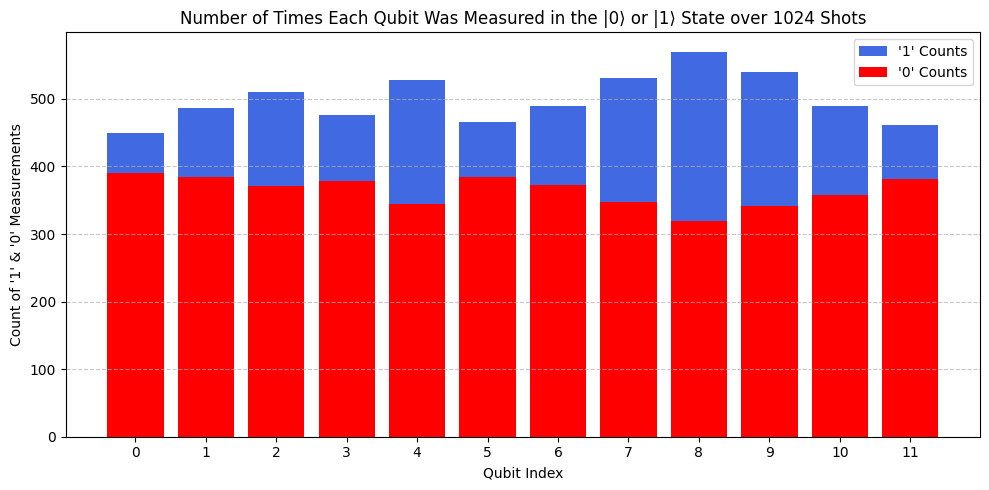

In [15]:
qubit_one_counts = np.zeros(n_qubits)
qubit_zero_counts = np.zeros(n_qubits)

# Loop through all measured bitstrings and accumulate 1s per qubit
for bitstring, count in counts.items():
    # Qiskit bitstrings are little-endian (qubit 0 is rightmost)
    bitstring = bitstring[::-1]  # reverse for correct qubit indexing
    for i, bit in enumerate(bitstring):
        if bit == '1':
            qubit_one_counts[i] += count
        elif bit == '0':
            qubit_zero_counts[i] += 1

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.bar(range(n_qubits), qubit_one_counts, color='royalblue', label="'1' Counts")
plt.bar(range(n_qubits), qubit_zero_counts, color='red', label="'0' Counts")
plt.xlabel("Qubit Index")
plt.ylabel("Count of '1' & '0' Measurements")
plt.title(f"Number of Times Each Qubit Was Measured in the |0⟩ or |1⟩ State over {k_shots} Shots")
plt.xticks(range(n_qubits))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

In [16]:
sv_df = pd.DataFrame(sv)
sv_df.head(10)
sv_df.to_csv("sv_vals.csv")

In [18]:
circuit_drawer(lqdrl, output="mpl")

In [65]:
circuit_drawer(tqc, output="mpl")

In [11]:
z = 1 - ((150 - 120) / (150 - 0))
print(z)

0.8


# Critic Network Ansatz Construction & Simulation
17 Inputs (actions & state)

In [19]:
#n_crit_qubits = 17
m_layers = 3
E_rem = 500e03
num_gus = 4
u = []
uav_pos = [0, 0, 0]
uav_v_max = 30
zeta_v = 1
uav_v = zeta_v * uav_v_max
noma_g = [1, 2, 3]
pwr_alloc = 1
action_vec = []

action_vec.append(uav_v)
for k in range(len(noma_g)):
    action_vec.append(noma_g[k])
action_vec.append(pwr_alloc)

crit_inp_vec = []

for i in range(len(uav_pos)):
    crit_inp_vec.append(uav_pos[i])
crit_inp_vec.append(E_rem)
for j in range(2*num_gus):
    u.append(j)
    crit_inp_vec.append(u[j])
crit_inp_vec.append(uav_v)
for k in range(len(noma_g)):
    crit_inp_vec.append(noma_g[k])
crit_inp_vec.append(pwr_alloc)

n_crit_qubits = len(crit_inp_vec)
print(n_crit_qubits)
theta_par_crit_inp_vec = np.arange(-np.pi, np.pi, (2*np.pi / (n_crit_qubits - 1)))

theta_crit_arr = x_angle_transformation(n_crit_qubits, crit_inp_vec)
theta_crit_par_arr = x_angle_transformation(n_crit_qubits, theta_par_crit_inp_vec)

#print(theta_crit_arr)

crit_lqdrl = build_ansatz(n_crit_qubits, m_layers, theta_crit_arr, theta_crit_par_arr)
#print(lqdrl)
sv = Statevector.from_instruction(crit_lqdrl)
#print(sv)

#crit_lqdrl.measure_all()
sim = AerSimulator()
crit_tqc = transpile(crit_lqdrl, sim)
result = sim.run(crit_tqc, shots=1024).result()
#counts = result.get_counts()

17


In [25]:
observable = SparsePauliOp("Z" + "I" * (crit_lqdrl.num_qubits - 1))
estimator = StatevectorEstimator()

result = estimator.run([(crit_lqdrl, observable)]).result()[0].data.evs
#q_val = result.data.evs
#q_value = result.data[0]['value']
print("Critic Q-value (⟨Z₀⟩):", result)
#print("Critic Q-value (⟨Z₀⟩):", q_value)

Critic Q-value (⟨Z₀⟩): 0.050824537446153756


In [21]:
def critic_param_shift_gradient(param_idx, state_vec, action_vec, shift=np.pi/2, Omega=1):
    full_input = state_vec + action_vec
    N = len(full_input)

    theta_arr = [np.tanh(x) for x in full_input]
    theta_par_arr = np.linspace(-np.pi, np.pi, N)

    theta_plus = theta_par_arr.copy()
    theta_minus = theta_par_arr.copy()
    theta_plus[param_idx] += shift
    theta_minus[param_idx] -= shift

    qc_plus = QuantumCircuit(N)
    qc_plus = lq_embed_1(qc_plus, N, theta_arr, theta_plus)
    for _ in range(1, m_layers):
        qc_plus = lq_embed_m(qc_plus, N, theta_arr, theta_plus)

    qc_minus = QuantumCircuit(N)
    qc_minus = lq_embed_1(qc_minus, N, theta_arr, theta_minus)
    for _ in range(1, m_layers):
        qc_minus = lq_embed_m(qc_minus, N, theta_arr, theta_minus)

    observable = SparsePauliOp("Z" + "I" * (N - 1))
    est = StatevectorEstimator()

    val_plus = est.run([(qc_plus, observable)]).result()[0].data.evs
    val_minus = est.run([(qc_minus, observable)]).result()[0].data.evs

    #grad = 0.5 * (val_plus - val_minus)
    grad = (val_plus - val_minus) / (2 * np.sinh(shift*Omega))
    return grad

In [ ]:
def actor_param_shift_gradient(idx, inp_vec, shift=np.pi/2, Omega=1):
    N = len(inp_vec)
    

In [22]:
grad = critic_param_shift_gradient(0, crit_inp_vec, action_vec)
print("Gradient w.r.t. θ₀:", grad)

Gradient w.r.t. θ₀: 6.633456685392133e-16


In [26]:
grad_arr = []
for i in range(n_crit_qubits):
    grad = critic_param_shift_gradient(i, crit_inp_vec, action_vec)
    grad_arr.append(grad)
print("Array of Gradient Parameters: ", grad_arr)

Array of Gradient Parameters:  [4.163336342344337e-16, 2.0539125955565396e-15, -4.718447854656915e-16, -3.608224830031759e-16, 3.608224830031759e-16, 3.552713678800501e-15, -8.604228440844963e-16, 1.27675647831893e-15, -8.881784197001252e-16, -1.1657341758564144e-15, -8.881784197001252e-16, -6.38378239159465e-16, 1.1657341758564144e-15, 3.608224830031759e-16, 3.885780586188048e-16, -8.326672684688674e-17, -3.3306690738754696e-16]


In [23]:
print("Gradient w.r.t. θ₀:", grad)

Gradient w.r.t. θ₀: 4.440892098500626e-16


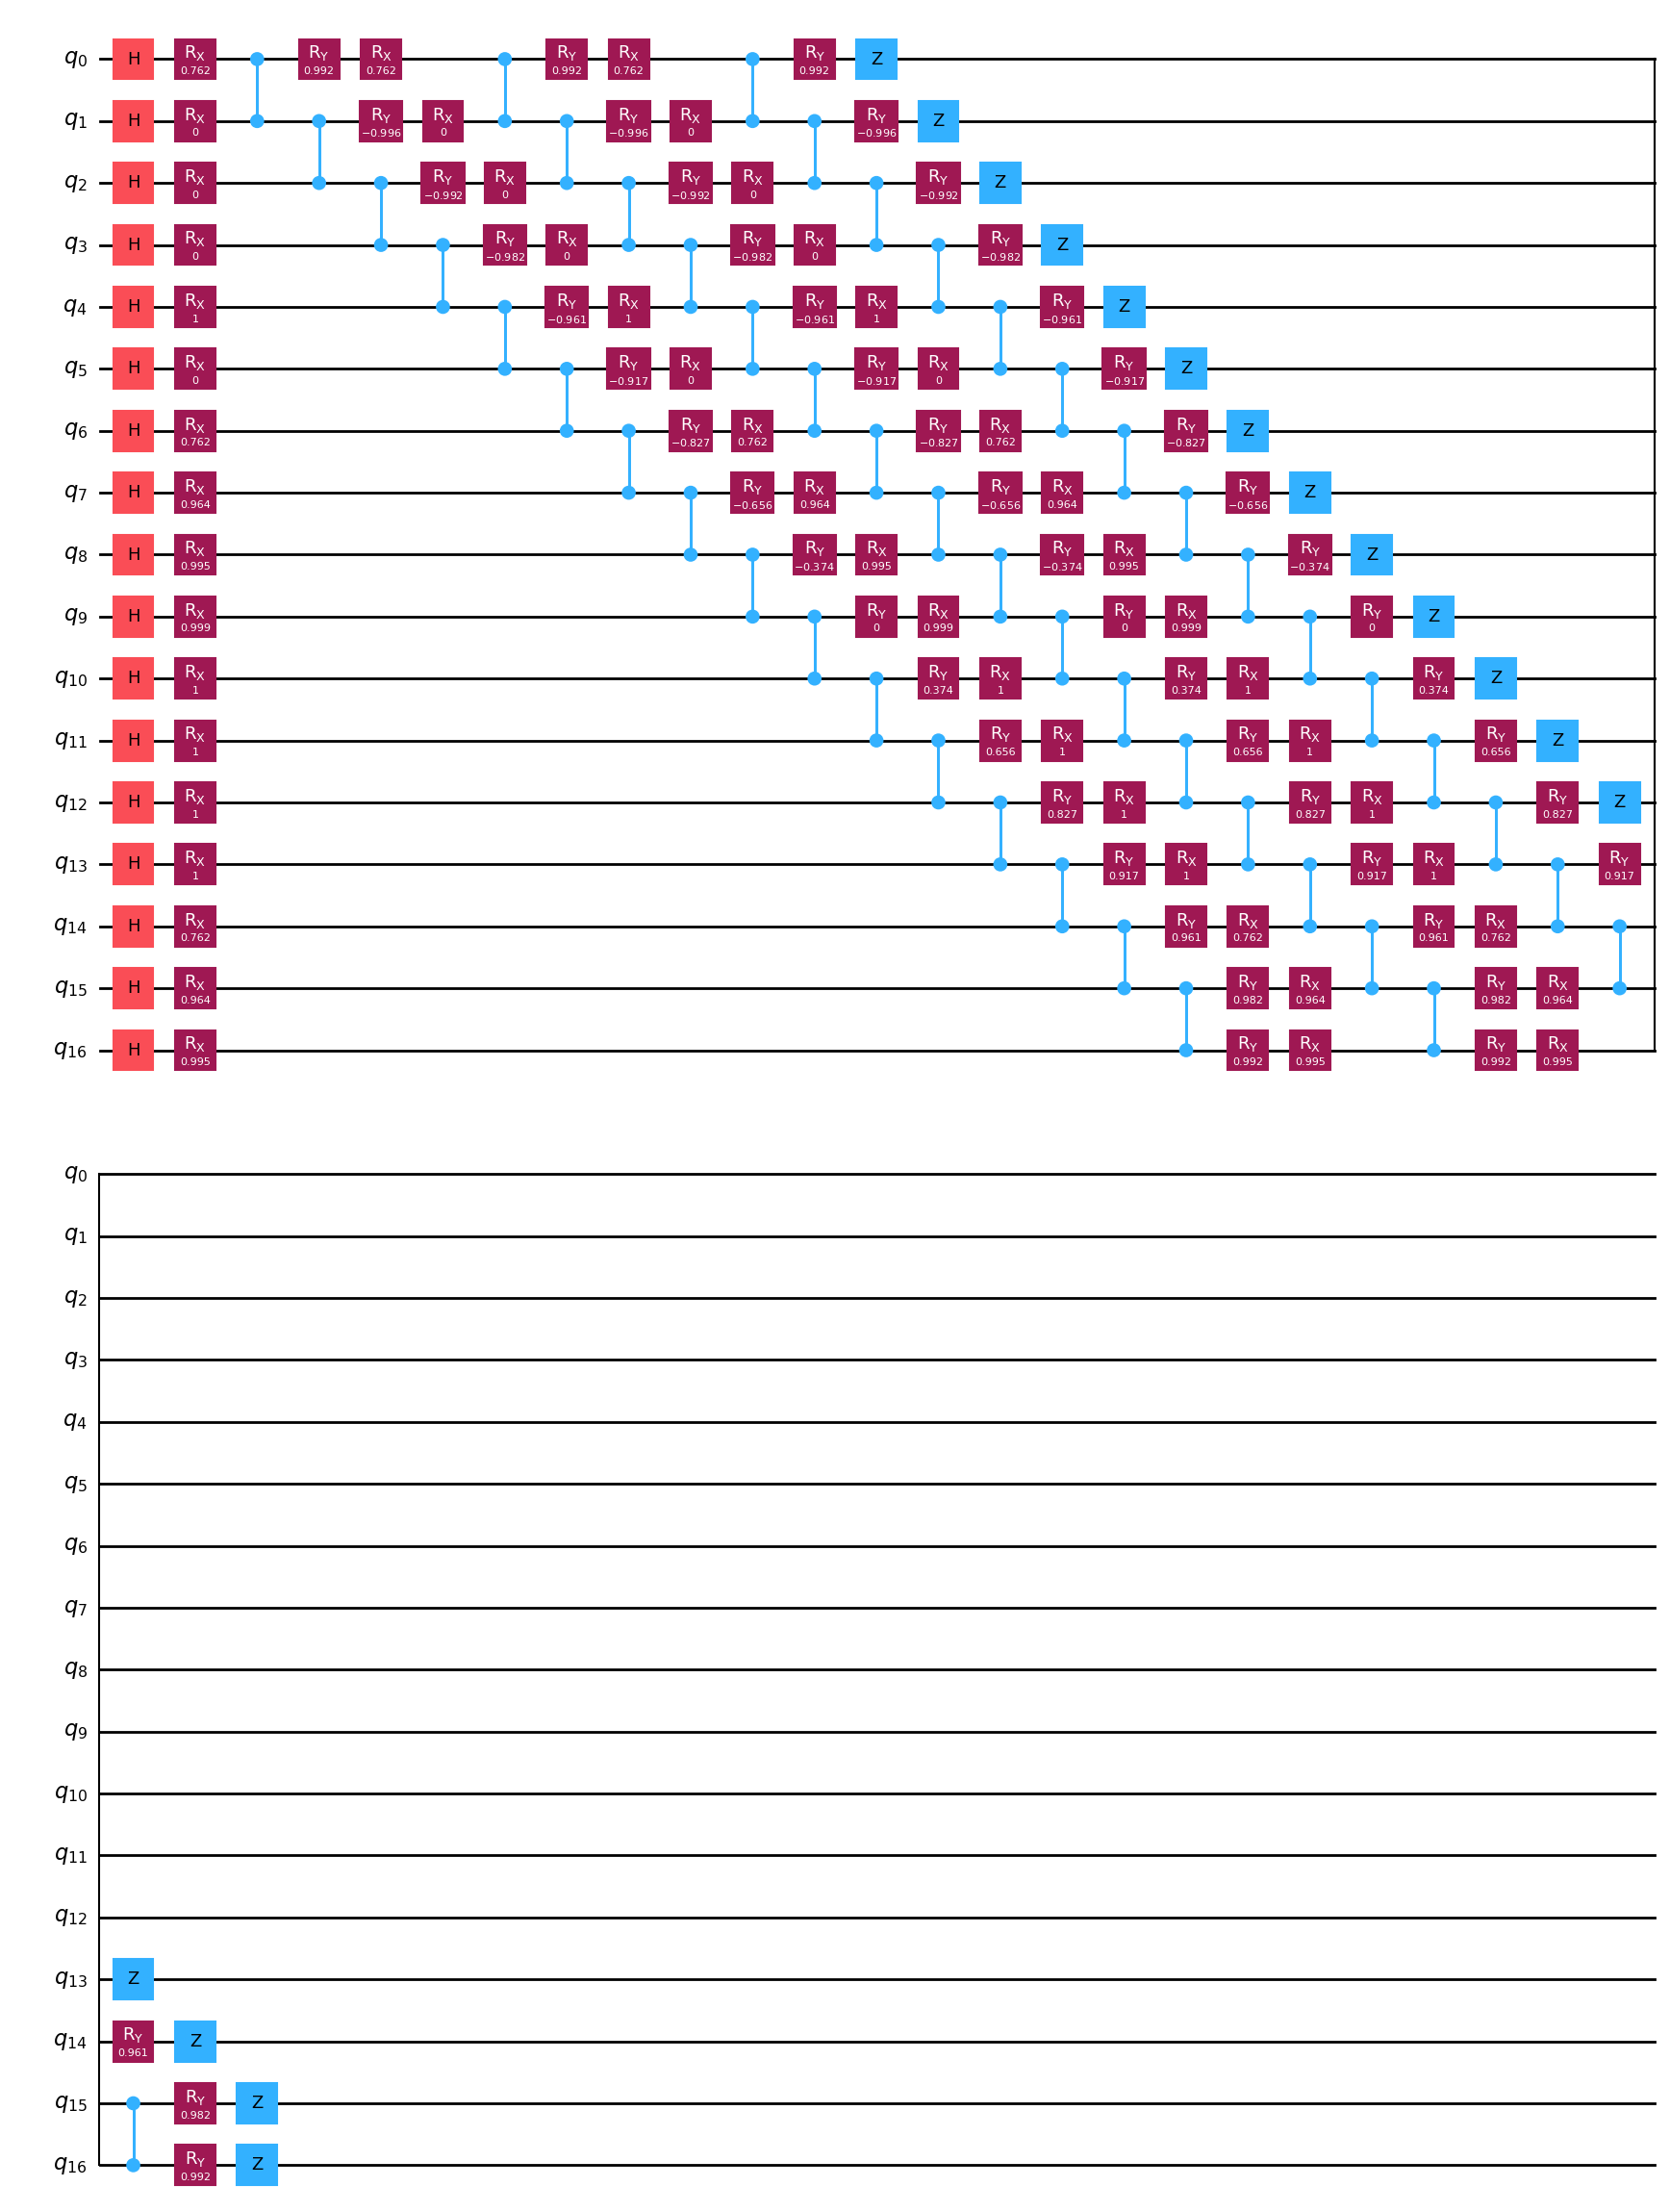

In [49]:
circuit_drawer(crit_lqdrl, output="mpl")

In [13]:
def compute_z_expectation_from_counts(counts, qubit_index, shots=1024):
    expectation = 0
    for bitstring, count in counts.items():
        bit = bitstring[::-1][qubit_index]  # Qiskit stores bitstrings big-endian
        z = 1 if bit == '0' else -1
        expectation += z * count
    return expectation / shots

In [ ]:
z0_expect_arr = []
tot = 0
k_shots = 1024 >> 2
#k_shots = 1024

for i in range(n_qubits):
    z0_expect = compute_z_expectation_from_counts(counts, qubit_index=i)
    z0_expect_arr.append(z0_expect)
    
for j in range(k_shots):
    tot += z0_expect
print(tot)

plt.figure(figsize=(12, 10))
plt.plot(z0_expect_arr)
plt.title("Z Expecation Values up to N = 12")
plt.xlabel("Qubits")
plt.ylabel("Z Expectation Value")
plt.grid()
plt.ylim(-0.15, 0.15)
plt.show()

In [36]:
# Function to perform the measurement operation (Z-basis transformation) on the quantum state output of the layerwise quantum embedding 
def meas_op():
    J = 0
    return J

In [37]:
# Function to perform the decoding operation on the output of the measurement operator 
# TODO: FINISH pauli_z() function for measurement operator
# Apply z-gate basis transformation to the entire evolved quantum state phi', sum all of these z-gate applications performed on each qubit and then divide the entire matrix by K_shot
# At present, I think that the y output from the decoding & measurement operation blocks should be a vector that is passed to the gradient descent algorithm
def decode_op(N, phi, k_shot):
    y = []
    z = pauli_z(N)
    for k in range(k_shot):
        y[k] += 1/k_shot * z * phi 
    return y

In [ ]:
# Function to perform the computation of the parameter shift rule for the gradient descent computation after the layerwise quantum embedding has occurred
# The output of this function will serve as the input for the RY gates in the layerwise quantum embedding ansatz
# Output theta' of this function should be a vector of Nx1 dimensions containing all of the updated theta values 
def param_shift(y):
    theta_dash = []

    return theta_dash

In [33]:
%load_ext autoreload
%autoreload 2
from uav_lqdrl_env import UAV_LQDRL_Environment

env = UAV_LQDRL_Environment()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
